In [1]:
import re
from pathlib import Path

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt

import renderapi
import icatapi

/home/skaracoban/miniconda3/envs/icat/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_3471376/2535530548.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Settings

In [2]:
# pandas display settings
pd.set_option('display.max_colwidth', 20)

# Indirectly enable autocomplete
%config Completer.use_jedi = False

# `altair` settings
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## 1) Set up `render-ws` environment
---

#### Connect to `render-ws`

In [3]:
# `render-ws` parameters
owner = 'skaracoban'
project = '20240530_SK001_2'
# Project directory
dir_project = Path("/long_term_storage/skaracoban/data/20240530_SK001/T1")

# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'http://localhost',
    'port': 8081,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://localhost',
 'port': 8081,
 'owner': 'skaracoban',
 'project': '20240530_SK001_2',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

#### Set montage stacks 

In [4]:
# Infer stack and section info
# ----------------------------
stacks = renderapi.render.get_stacks_by_owner_project(render=render, **render_connect_params)
stacks_2_montage = ['EM_himag']
match_collections = {k: v for k, v in zip(stacks_2_montage,
                                          [f"{project}_{stack}_points" for stack in stacks_2_montage])}

# Output
# ------
out = f"""\
project directory... {dir_project} | Exists: {dir_project.exists()}
all stacks.......... {stacks}
stacks to montage... {stacks_2_montage}
match collections... {match_collections}
...
"""
print(out)

# Create project DataFrame
# ------------------------
df_project = icatapi.create_stacks_DataFrame(stacks=stacks_2_montage,
                                             render=render, **render_connect_params)
df_project.groupby('stack')\
          .apply(lambda x: x.head(3))

project directory... /long_term_storage/skaracoban/data/20240530_SK001/T1 | Exists: True
all stacks.......... ['exc_470nm', 'EM_lomag', 'EM_himag']
stacks to montage... ['EM_himag']
match collections... {'EM_himag': '20240530_SK001_2_EM_himag_points'}
...



/tmp/ipykernel_3471376/983272906.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.head(3))


tileId    z   width  height   minint   maxint  \
stack                                                                    
EM_himag 0  aaa_EM_himag-S00...  0.0  4096.0  4096.0  31417.0  34244.0   
         1  aab_EM_himag-S00...  0.0  4096.0  4096.0  31417.0  34244.0   
         2  aac_EM_himag-S00...  0.0  4096.0  4096.0  31417.0  34244.0   

                   imagePyramid               tforms     stack sectionId  \
stack                                                                      
EM_himag 0  [0, 1, 2, 3, 4, ...  [M=[[1.000000,0....  EM_himag      S002   
         1  [0, 1, 2, 3, 4, ...  [M=[[1.000000,0....  EM_himag      S002   
         2  [0, 1, 2, 3, 4, ...  [M=[[1.000000,0....  EM_himag      S002   

            imageRow  imageCol       stageX       stageY  
stack                                                     
EM_himag 0        11         0 -7044.136091 -1499.400068  
         1        11         1 -7026.574242 -1499.432230  
         2        11         2 -7008.994138 -1499.453632

## 2) Generate point matches
---

#### Collect tile pairs

Tile pairs are any two tiles that overlap with each other (possibly including diagonally). Collection of tile pairs is generated from a `render-python` client script. This client selects a set of tiles `p` based on its position in a stack and then searches for nearby `q` tiles using geometric parameters.

script | code
------ | ----
client script | [`renderapi.client.tilePairClient`](https://github.com/fcollman/render-python/blob/721ac8845e3067af6c81f3c67f2c0fa24fb1723c/renderapi/client/client_calls.py#L129)
java script | [`TilePairClient.java`](https://github.com/saalfeldlab/render/blob/master/render-ws-java-client/src/main/java/org/janelia/render/client/TilePairClient.java)

In [5]:
from icatapi.montage import get_tile_pairs_4_montage

In [6]:
# Initialize tile pairs DataFrame
df_pairs = pd.DataFrame()

# Loop through montage stacks
for stack in tqdm(stacks_2_montage):

    # Get tile pairs for each stack
    df = get_tile_pairs_4_montage(stack=stack,
                                  render=render, **render_connect_params)
    df_pairs = pd.concat([df_pairs, df])

# Preview
out = f"{len(df_pairs)} tile pairs"
print(out + '\n' + '.'*len(out))

df_pairs.reset_index(drop=True, inplace=True)
df_pairs.groupby('stack')\
        .apply(lambda x: x.sample(7))

  0%|          | 0/1 [00:00<?, ?it/s]

org.janelia.render.client.TilePairClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.TilePairClient --baseDataUrl http://localhost:8081/render-ws/v1 --owner skaracoban --project 20240530_SK001_2 --stack EM_himag --minZ 0.0 --maxZ 0.0 --toJson /tmp/tmp7gg18_wa.json


13:00:02.263 [main] INFO  [org.janelia.render.client.ClientRunner] run: entry
13:00:02.444 [main] INFO  [org.janelia.render.client.TilePairClient] runClient: entry, parameters={
  "renderWeb" : {
    "baseDataUrl" : "http://localhost:8081/render-ws/v1",
    "owner" : "skaracoban",
    "project" : "20240530_SK001_2"
  },
  "stack" : "EM_himag",
  "minZ" : 0.0,
  "maxZ" : 0.0,
  "xyNeighborFactor" : 0.9,
  "zNeighborDistance" : 2,
  "excludeCornerNeighbors" : true,
  "excludeCompletelyObscuredTiles" : true,
  "excludeSameLa

/home/skaracoban/render_code/iCAT-workflow/icatapi/montage.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pairs = pd.concat([df_pairs, df])


org.janelia.render.client.TilePairClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.TilePairClient --baseDataUrl http://localhost:8081/render-ws/v1 --owner skaracoban --project 20240530_SK001_2 --stack EM_himag --minZ 1.0 --maxZ 1.0 --toJson /tmp/tmpcgokckf4.json


13:00:03.208 [main] INFO  [org.janelia.render.client.ClientRunner] run: entry
13:00:03.401 [main] INFO  [org.janelia.render.client.TilePairClient] runClient: entry, parameters={
  "renderWeb" : {
    "baseDataUrl" : "http://localhost:8081/render-ws/v1",
    "owner" : "skaracoban",
    "project" : "20240530_SK001_2"
  },
  "stack" : "EM_himag",
  "minZ" : 1.0,
  "maxZ" : 1.0,
  "xyNeighborFactor" : 0.9,
  "zNeighborDistance" : 2,
  "excludeCornerNeighbors" : true,
  "excludeCompletelyObscuredTiles" : true,
  "excludeSameLa

/tmp/ipykernel_3471376/707983636.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(7))


stack    z p.groupId                 p.id p.relativePosition  \
stack                                                                           
EM_himag 746  EM_himag  2.0      S001  aej_EM_himag-S00...              RIGHT   
         234  EM_himag  0.0      S002  aes_EM_himag-S00...             BOTTOM   
         150  EM_himag  0.0      S002  ada_EM_himag-S00...             BOTTOM   
         44   EM_himag  0.0      S002  aaw_EM_himag-S00...              RIGHT   
         142  EM_himag  0.0      S002  acw_EM_himag-S00...             BOTTOM   
         167  EM_himag  0.0      S002  adj_EM_himag-S00...             BOTTOM   
         110  EM_himag  0.0      S002  acf_EM_himag-S00...             BOTTOM   

             q.groupId                 q.id q.relativePosition  
stack                                                           
EM_himag 746      S001  aek_EM_himag-S00...               LEFT  
         234      S002  afl_EM_himag-S00...                TOP  
         150      S002  adl_EM_himag-S00...                TOP  
         44       S002  aax_EM_himag-S00...               LEFT  
         142      S002  adp_EM_himag-S00...                TOP  
         167      S002  aea_EM_himag-S00...                TOP  
         110      S002  ack_EM_himag-S00...                TOP

### Run `pointMatchClient`
##### Set `SIFT` & `RANSAC` parameters

In [7]:
from renderapi.client import (MatchDerivationParameters,
                              FeatureExtractionParameters,
                              SiftPointMatchOptions)

In [8]:
# `RANSAC` parameters
match_params = MatchDerivationParameters(matchIterations=None,
                                         matchMaxEpsilon=25,        # maximal alignment error
                                         matchMaxNumInliers=None,
                                         matchMaxTrust=None,
                                         matchMinInlierRatio=0.05,  # minimal inlier ratio
                                         matchMinNumInliers=7,      # minimal number of inliers
                                         matchModelType='RIGID',    # expected transformation
                                         matchRod=0.92)             # closest/next closest ratio
# `SIFT` parameters
feature_params = FeatureExtractionParameters(SIFTfdSize=8,          # feature descriptor size
                                             SIFTmaxScale=0.20,     # (width/height *) maximum image size
                                             SIFTminScale=0.05,     # (width/height *) minimum image size
                                             SIFTsteps=7)           # steps per scale octave
# Combined `SIFT` & `RANSAC` parameters
sift_options = SiftPointMatchOptions(**{**match_params.__dict__,
                                        **feature_params.__dict__})
# Add clipping options
sift_options.clipWidth = 1000   # N pixels included in rendered clips of LEFT/RIGHT oriented montage tiles
sift_options.clipHeight = 1000  # N pixels included in rendered clips of TOP/BOTTOM oriented montage tiles

# Preview
list(sift_options.to_java_args())

['--SIFTfdSize',
 '8',
 '--SIFTmaxScale',
 '0.2',
 '--SIFTminScale',
 '0.05',
 '--SIFTsteps',
 '7',
 '--matchMaxEpsilon',
 '25',
 '--matchMinInlierRatio',
 '0.05',
 '--matchMinNumInliers',
 '7',
 '--matchModelType',
 'RIGID',
 '--matchRod',
 '0.92',
 '--clipWidth',
 '1000',
 '--clipHeight',
 '1000']

#### \*\****COMPUTATIONALLY EXPENSIVE*** \**

##### Run `pointMatchClient` on `N_cores`

In [9]:
from icatapi.montage import generate_point_matches

In [10]:
# Set number of cores and batch size
N_cores = 40
batch_size = 1

# Generate point matches
generate_point_matches(df_pairs,
                       match_collections=match_collections,
                       sift_options=sift_options,
                       excludeAllTransforms=True,
                       N_cores=N_cores,
                       batch_size=batch_size,
                       render=render, **render_connect_params)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

org.janelia.render.client.PointMatchClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.PointMatchClient --baseDataUrl http://localhost:8081/render-ws/v1 --owner skaracoban --collection 20240530_SK001_2_EM_himag_points --SIFTfdSize 8 --SIFTmaxScale 0.2 --SIFTminScale 0.05 --SIFTsteps 7 --matchMaxEpsilon 25 --matchMinInlierRatio 0.05 --matchMinNumInliers 7 --matchModelType RIGID --matchRod 0.92 --firstCanvasPosition BOTTOM http://localhost:8081/render-ws/v1/owner/skaracoban/project/20240530_SK001_2/stack/EM_himag/tile/aaa_EM_himag-S002-00000x00011/render-parameters?filter=false&normalizeForMatching=true&renderWithoutMask=false&excludeAllTransforms=true http://localhost:8081/render-ws/v1/owner/skaracoban/project/20240530_SK001_2/stack/EM_himag/tile/aax_EM_himag-S002-00000x00010/render-p

## 3) Analyze point matches
---

### Collect point matches
Sort of forced to iterate through tile pairs because no data is returned for tile pairs with no matches

In [ ]:
# Collect point matches from montage stacks
df_matches = pd.DataFrame()
for stack in tqdm(stacks_2_montage):
    # Get matches per stack
    df = icatapi.montage.get_matches_within_stack(stack=stack,
                                                  match_collection=match_collections[stack],
                                                  render=render)
    df_matches = pd.concat([df_matches, df])

# Merge with DataFrame of tile pairs to also get empty matches
df_matches = pd.merge(
    df_matches,
    df_pairs.rename(columns={'p.groupId': 'pGroupId',
                             'q.groupId': 'qGroupId',
                             'p.id': 'pId',
                             'q.id': 'qId'})\
            .drop(['p.relativePosition',
                   'q.relativePosition'], axis=1, errors='ignore'),
    how='outer',
    on=['stack', 'z', 'pGroupId', 'pId', 'qGroupId', 'qId'])

# Add row/col indices
df_matches[['pc', 'pr']] = np.stack(df_matches['pId'].apply(lambda x:\
                                    [int(i) for i in re.findall(r'\d+', x)[-2:]]))
df_matches[['qc', 'qr']] = np.stack(df_matches['qId'].apply(lambda x:\
                                    [int(i) for i in re.findall(r'\d+', x)[-2:]]))

# Preview
out = f"""\
{len(df_matches.dropna())} / \
{len(df_matches)} \
({len(df_matches.dropna())/len(df_matches):.1%}) \
tile pair matches"""
print(out + '\n' + '.'*len(out))
df_matches.groupby('stack')\
          .apply(lambda x: x.sample(3))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/home/skaracoban/render_code/iCAT-workflow/icatapi/montage.py:276: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_matches = pd.concat([df_matches, df])


792 / 792 (100.0%) tile pair matches
....................................


/tmp/ipykernel_1969123/254678892.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(3))


stack    z pGroupId             pId  pc  pr qGroupId  \
stack                                                                   
EM_himag 323  EM_himag  1.0     S002   t030_z1_y9_x6   9   6     S002   
         115  EM_himag  0.0     S001  t060_z0_y6_x11   6  11     S001   
         253  EM_himag  0.0     S001  t132_z0_y0_x11   0  11     S001   

                         qId  qc  qr      N            matches.p  \
stack                                                              
EM_himag 323   t041_z1_y8_x6   8   6  134.0  [[1410.384636565...   
         115  t061_z0_y6_x10   6  10  106.0  [[176.4325931212...   
         253  t133_z0_y0_x10   0  10   88.0  [[460.1154716512...   

                        matches.q            matches.w  
stack                                                   
EM_himag 323  [[1614.057959931...  [1.0, 1.0, 1.0, ...  
         115  [[3751.933457968...  [1.0, 1.0, 1.0, ...  
         253  [[4024.571473192...  [1.0, 1.0, 1.0, ...

### Heatmaps of point matches

#### East-West point matches

In [ ]:
icatapi.plotting.plot_matches_within_section(df_matches,
                                             direction='east-west',
                                             width=150,
                                             height=150)

alt.FacetChart(...)

#### North-South point matches

In [ ]:
icatapi.plotting.plot_matches_within_section(df_matches,
                                             direction='north-south',
                                             width=150,
                                             height=150)

alt.FacetChart(...)

## 4) Montage
---

#### Edit `montage.json`

In [ ]:
import json
from pprint import pprint

In [ ]:
# Load montage json template
template_montage_json = Path('/home/skaracoban/render_code/iCAT-workflow/templates/montage.json')
with template_montage_json.open('r') as json_data:
    montage_settings = json.load(json_data)

# Edit montage settings for each montage stack
for (stack, z, sectionId), df in df_project.loc[(df_project['stack'].isin(stacks_2_montage))] \
                                           .groupby(['stack', 'z', 'sectionId']):

    # Edit BigFeta solver schema
    montage_settings['first_section'] = z
    montage_settings['last_section'] = z
    montage_settings['solve_type'] = 'montage'
    montage_settings['transformation'] = 'rigid'
    montage_settings['log_level'] = 'INFO'

    # Edit input stack data
    montage_settings['input_stack']['owner'] = owner
    montage_settings['input_stack']['project'] = project
    montage_settings['input_stack']['name'] = stack

    # Edit point match stack data
    montage_settings['pointmatch']['owner'] = owner
    montage_settings['pointmatch']['name'] = match_collections[stack]

    # Edit output stack data
    montage_settings['output_stack']['owner'] = owner
    montage_settings['output_stack']['project'] = project
    montage_settings['output_stack']['name'] = f'{stack}_montaged'

    # Edit regularization parameters
    montage_settings['regularization']['default_lambda'] = 0.005      # default: 0.005
    montage_settings['regularization']['translation_factor'] = 0.005  # default: 0.005
    montage_settings['regularization']['thinplate_factor'] = 1e-5     # default: 1e-5

    # Export montage settings to
    montage_json = dir_project / '_jsons_montage' / stack / f"{sectionId}_montage.json"
    montage_json.parent.mkdir(parents=True, exist_ok=True)
    with montage_json.open('w') as json_data:
        json.dump(montage_settings, json_data, indent=2)

# Sample montage json
print(montage_json)
print('...')
pprint(montage_settings)

/long_term_storage/skaracoban/data/20240530_SK001/T1/t/_jsons_montage/EM_himag/S003_montage.json
...
{'close_stack': 'True',
 'first_section': 2.0,
 'hdf5_options': {'chunks_per_file': -1, 'output_dir': ''},
 'input_stack': {'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
                 'collection_type': 'stack',
                 'db_interface': 'render',
                 'host': 'localhost',
                 'name': 'EM_himag',
                 'owner': 'skaracoban',
                 'port': 8081,
                 'project': '20240530_SK001'},
 'last_section': 2.0,
 'log_level': 'INFO',
 'matrix_assembly': {'cross_pt_weight': 1.0,
                     'depth': 2,
                     'inverse_dz': 'True',
                     'montage_pt_weight': 1.0,
                     'npts_max': 500,
                     'npts_min': 5},
 'output_mode': 'stack',
 'output_stack': {'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
  

### Run `BigFeta` montage

In [ ]:
import os
import subprocess

In [ ]:
# Path to `BigFeta`
cwd = Path.cwd().as_posix()
BigFeta_dir = Path('/home/catmaid/BigFeta/')

# Loop through each section of montage stacks
for (stack, z, sectionId), df in tqdm(df_project.loc[(df_project['stack'].isin(stacks_2_montage))]\
                                                .groupby(['stack', 'z', 'sectionId'])):

    # Select montage json
    montage_json = dir_project / '_jsons_montage' / stack / f"{sectionId}_montage.json"

    # Call `BigFeta.BigFeta` process -- have to switch to BigFeta directory
    os.chdir(BigFeta_dir.as_posix())
    subprocess.run(['python', '-m', 'bigfeta.bigfeta', '--input_json', montage_json.as_posix()])
    os.chdir(cwd)

  0%|          | 0/3 [00:00<?, ?it/s]

/home/skaracoban/miniconda3/envs/icat/lib/python3.10/site-packages/argschema/utils.py:346: FutureWarning: '--transform_apply' is using old-style command-line syntax with each element as a separate argument. This will not be supported in argschema after 2.0. See http://argschema.readthedocs.io/en/master/user/intro.html#command-line-specification for details.
  warnings.warn(warn_msg, FutureWarning)
INFO:bigfeta.utils:
 loaded 144 tile specs from 1 zvalues in 0.1 sec using interface: render
INFO:__main__: A created in 0.6 seconds
INFO:__main__:
 solved in 0.0 sec
 precision [norm(Kx-Lm)/norm(Lm)] = 8.2e-06
 error     [norm(Ax-b)] = 504.714
 [mean(Ax) +/- std(Ax)] : 0.0 +/- 1.5
 [mean(error mag) +/- std(error mag)] : 1.1 +/- 0.9
/home/catmaid/BigFeta/bigfeta/transform/rigid_model.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecat

## 5) Inspect montaged stacks
---


#### Tile map

  0%|          | 0/3 [00:00<?, ?it/s]

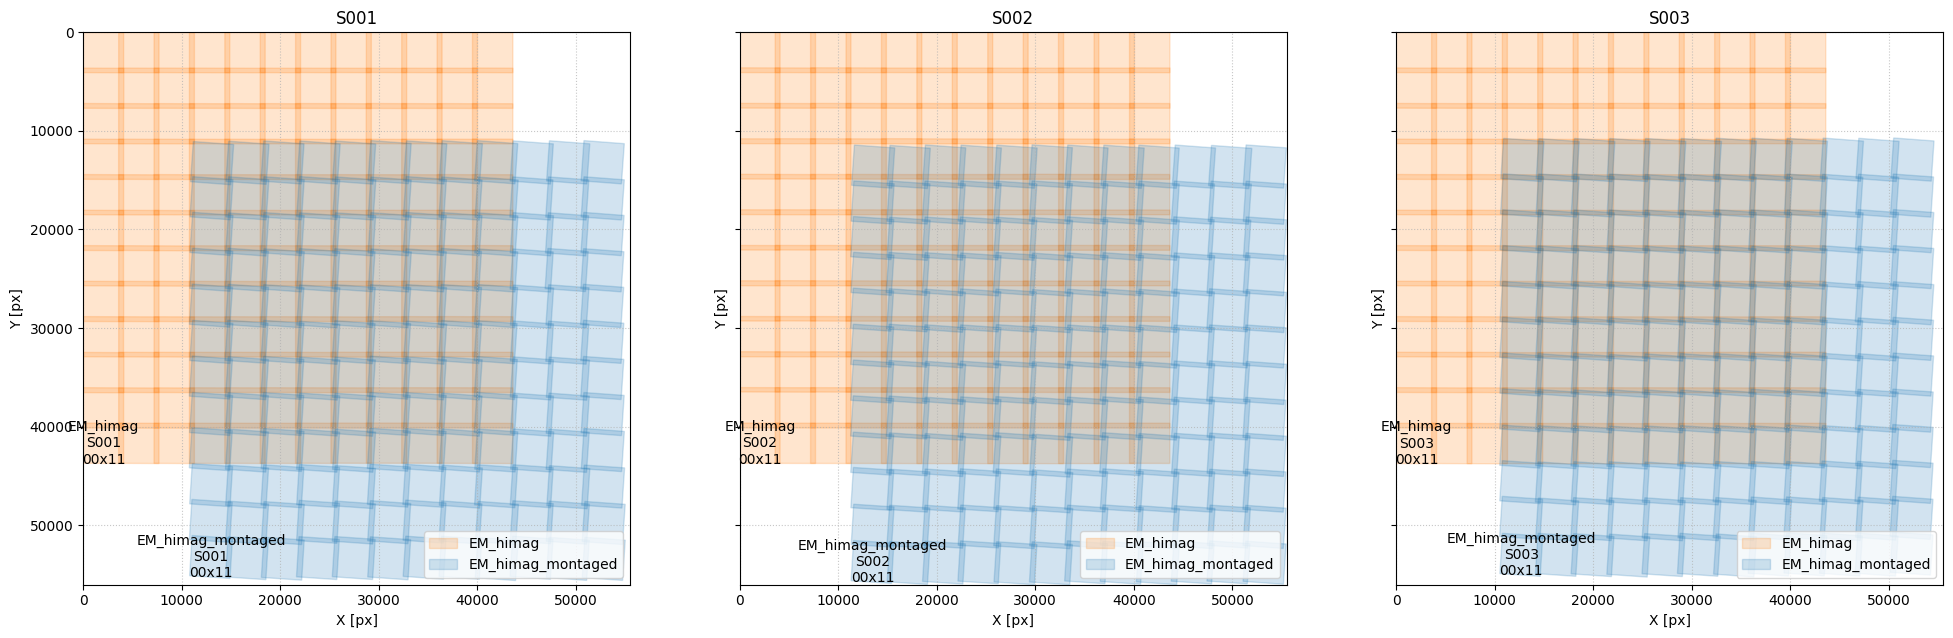

In [ ]:
stacks = renderapi.render.get_stacks_by_owner_project(render=render, **render_connect_params)
stacks_2_plot = [stack for stack in stacks if '_montaged' in stack] +\
                 stacks_2_montage

icatapi.plot_tile_map(stacks=stacks_2_plot,
                      render=render, **render_connect_params)

#### Plot stacks

  0%|          | 0/2 [00:00<?, ?it/s]

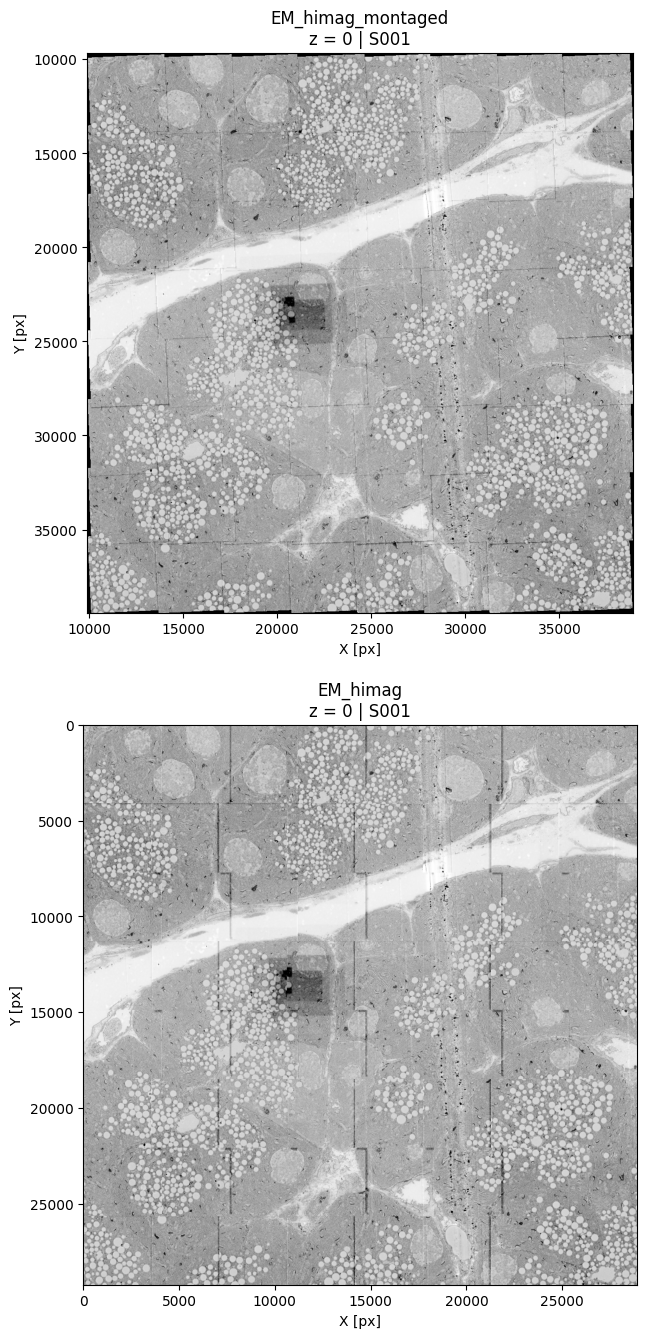

In [ ]:
icatapi.plot_stacks(stacks_2_plot,
                    maxTileSpecsToRender=1000,
                    render=render)

In [ ]:
stacks_2_plot

['EM_himag_montaged', 'EM_himag']

## Scale montage
---

In [ ]:
from matplotlib.transforms import Affine2D as AffineMPL
from renderapi.transform import AffineModel as AffineRender

from icatapi.render_pandas import create_stack_DataFrame, upload_stack_DataFrame
from icatapi.render_transforms import scale_stack

#### Determine scaling factor
Scale each tileset by the same factor. So determine the average scale and multiply by that

In [ ]:
# Collect scaling factors
scales_x = []
scales_y = []

# Create stack DataFrame
df_stack = create_stack_DataFrame(stack='EM_himag_montaged',
                                  render=render, **render_connect_params)

# Loop through sections
for z, layer in tqdm(df_stack.groupby('z'),
                     total=len(df_stack['z'].unique())):

    # Get transform data
    columns = ['M00', 'M10', 'M01', 'M11', 'B0', 'B1']
    tforms = pd.DataFrame(layer['tforms']\
               .apply(lambda x: x[0].dataString)\
               .str.split(' ', expand=True).values, columns=columns)\
               .astype(float)

    # Extract scale from affine transform
    M = AffineMPL(np.array([[tforms['M00'].mean(), tforms['M01'].mean(), 0],
                            [tforms['M10'].mean(), tforms['M11'].mean(), 0],
                            [                   0,                    0, 1]]))
    R, S = np.linalg.qr(M.get_matrix())
    mask = np.diag(S) < 0.
    S[mask, :] *= -1.
    # Set scale
    sx = 1/S[0,0]
    sy = 1/S[1,1]

    # Collect scaling factors
    scales_x.append(sx)
    scales_y.append(sy)

# Put into arrays
scales_x = np.array(scales_x)
scales_y = np.array(scales_y)
# Find average
sx = scales_x.mean()
sy = scales_y.mean()

# Out
sx, sy

  0%|          | 0/1 [00:00<?, ?it/s]

(0.9989608652701559, 0.9989608652701557)

#### Scale stack

In [ ]:
# Scale stack
scale_stack(stack_in='EM_himag_montaged',
            stack_out='EM_himag_stitched',
            sx=sx,
            sy=sy,
            translate=True,
            render=render, **render_connect_params)

Creating tile specifications for EM_himag_stitched...
Importing tile specifications to EM_himag_stitched...
org.janelia.render.client.ImportJsonClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.ImportJsonClient --baseDataUrl http://localhost:8081/render-ws/v1 --owner skaracoban --project 20240219_PD05_final_test --stack EM_himag_stitched /tmp/tmp0x1wqb54.json


12:00:53.646 [main] INFO  [org.janelia.render.client.ClientRunner] run: entry
12:00:53.806 [main] INFO  [org.janelia.render.client.ImportJsonClient] runClient: entry, parameters={
  "renderWeb" : {
    "baseDataUrl" : "http://localhost:8081/render-ws/v1",
    "owner" : "skaracoban",
    "project" : "20240219_PD05_final_test"
  },
  "tileSpecValidator" : { },
  "stack" : "EM_himag_stitched",
  "tileFiles" : [
    "/tmp/tmp0x1w

#### Plot tiles

  0%|          | 0/1 [00:00<?, ?it/s]

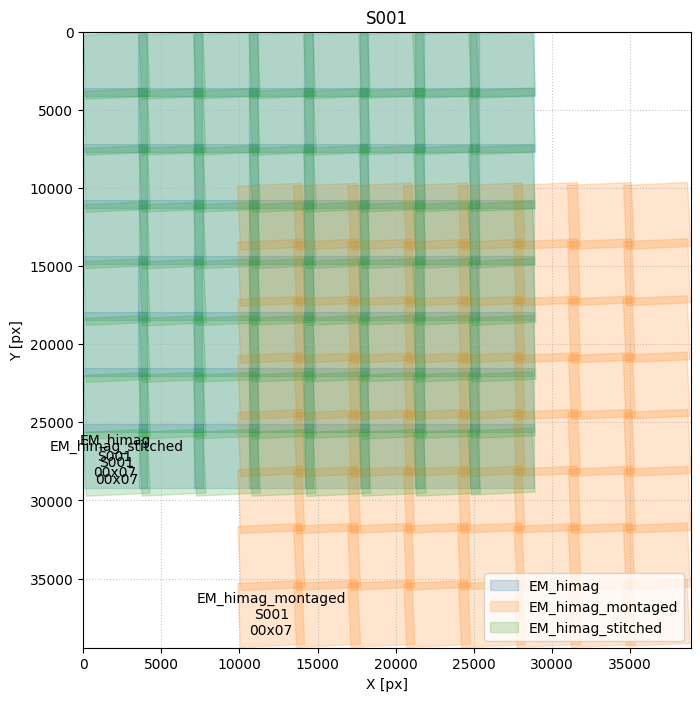

In [ ]:
stacks_2_plot = stacks_2_montage + ['EM_himag_montaged', 'EM_himag_stitched']

icatapi.plotting.plot_tile_map(stacks=stacks_2_plot,
                               render=render)

In [ ]:
stacks_2_montage

['EM_himag']